# Simplified PESI Analysis on STARR-OMOP
Richard Yoo (rmyoo@stanford.edu)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prework" data-toc-modified-id="Prework-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prework</a></span></li><li><span><a href="#Cohort-Construction" data-toc-modified-id="Cohort-Construction-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Cohort Construction</a></span><ul class="toc-item"><li><span><a href="#Identify-Patients-with-Pulmonary-Embolism" data-toc-modified-id="Identify-Patients-with-Pulmonary-Embolism-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Identify Patients with Pulmonary Embolism</a></span></li><li><span><a href="#Remove-Patients-without-Race-Information" data-toc-modified-id="Remove-Patients-without-Race-Information-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Remove Patients without Race Information</a></span></li><li><span><a href="#Remove-Patients-without-Gender-Information" data-toc-modified-id="Remove-Patients-without-Gender-Information-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Remove Patients without Gender Information</a></span></li><li><span><a href="#Filter-Encounters-by-Age" data-toc-modified-id="Filter-Encounters-by-Age-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Filter Encounters by Age</a></span></li></ul></li><li><span><a href="#Outcomes-Assessment" data-toc-modified-id="Outcomes-Assessment-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Outcomes Assessment</a></span></li><li><span><a href="#sPESI-Indicators" data-toc-modified-id="sPESI-Indicators-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>sPESI Indicators</a></span><ul class="toc-item"><li><span><a href="#Age" data-toc-modified-id="Age-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Age</a></span></li><li><span><a href="#History-of-Cancer" data-toc-modified-id="History-of-Cancer-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>History of Cancer</a></span></li><li><span><a href="#History-of-Chronic-Cardiopulmonary-Disease" data-toc-modified-id="History-of-Chronic-Cardiopulmonary-Disease-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>History of Chronic Cardiopulmonary Disease</a></span></li><li><span><a href="#Heart-Rate" data-toc-modified-id="Heart-Rate-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Heart Rate</a></span></li><li><span><a href="#Systolic-BP" data-toc-modified-id="Systolic-BP-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Systolic BP</a></span></li><li><span><a href="#O2-Saturation" data-toc-modified-id="O2-Saturation-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>O2 Saturation</a></span></li></ul></li><li><span><a href="#Compute-sPESI" data-toc-modified-id="Compute-sPESI-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Compute sPESI</a></span></li><li><span><a href="#Obtain-Cohort-Statistics" data-toc-modified-id="Obtain-Cohort-Statistics-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Obtain Cohort Statistics</a></span></li><li><span><a href="#Survival-Analysis" data-toc-modified-id="Survival-Analysis-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Survival Analysis</a></span><ul class="toc-item"><li><span><a href="#Create-Survival-Table" data-toc-modified-id="Create-Survival-Table-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Create Survival Table</a></span></li><li><span><a href="#Study-sPESI-Concordance" data-toc-modified-id="Study-sPESI-Concordance-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Study sPESI Concordance</a></span></li><li><span><a href="#Observe-Negative-Incidents" data-toc-modified-id="Observe-Negative-Incidents-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Observe Negative Incidents</a></span></li></ul></li></ul></div>

In [1]:
import datetime
import lifelines
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import qgrid
import re
import scipy.stats as stats
import statsmodels.api as sm
import swifter
import multiprocessing
import pickle

from collections import defaultdict
from dateutil.relativedelta import relativedelta
from google.cloud import bigquery

np.random.seed(0)

%matplotlib inline

## Prework

Below project setup assumes access to STARR-OMOP identified through Nero.

In [2]:
# Project setup.
user_id = 'rmyoo'
nero_gcp_project = 'som-nero-phi-nigam-starr'
project_id = 'som-nero-phi-nigam-starr'
dataset_id = 'shahlab_omop_cdm5_subset_2021_09_29'
work_project_id = nero_gcp_project
death_dataset_id = 'death'

In [3]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/home/{}/.config/gcloud/application_default_credentials.json'.format(user_id)
os.environ['GCLOUD_PROJECT'] = nero_gcp_project

In [4]:
# Create client.
client = bigquery.Client(project=work_project_id)

/home/rmyoo/.conda/envs/rmyoo_env/lib/python3.9/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


## Cohort Construction

Supplementary material in [Aujeski et al](https://www.atsjournals.org/doi/full/10.1164/rccm.200506-862OC) describes cohort construction as follows:
- We included inpatients age 18 or older who were discharged with a primary diagnosis of PE based on the following ICD-9-CM codes: 415.1, 415.11, 415.19, and 673.20-24. 
- To ensure that we identified the most severely ill patients with PE as the primary reason for hospitalization, we also included inpatients with or a secondary diagnosis code for PE and one of the following primary codes that may represent complications or treatments of this condition: respiratory failure (518.81), cardiogenic shock (785.51), cardiac arrest (427.5), secondary pulmonary hypertension (416.8), syncope (780.2), thrombolysis (99.10), and intubation/mechanical ventilation (96.04, 96.05, 96.70-96.72).

OMOP CDM does not have the concept of primary or secondary diagnosis. Instead just focus on the PE ICD-9-CM codes.

### Identify Patients with Pulmonary Embolism

In [5]:
pe_concept_code = """
"415.1",
"415.11",
"415.19",
"673.20",
"673.21",
"673.22",
"673.23",
"673.24"
"""

In [6]:
query = """ 
SELECT 
  * 
FROM
  `{project_id}.{dataset_id}.concept`
WHERE 
  domain_id = 'Condition' AND
  vocabulary_id = 'ICD9CM' AND
  concept_code IN ({pe_concept_code})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'pe_concept_code': pe_concept_code})

result = client.query(query).to_dataframe()
result

,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_DATE,valid_end_DATE,invalid_reason,load_table_id,load_row_id
0,44829168,"Obstetrical blood-clot embolism, delivered, wi...",Condition,ICD9CM,5-dig billing code,None,673.22,1970-01-01,2099-12-31,None,athena_vocab,NaN
1,44823112,Iatrogenic pulmonary embolism and infarction,Condition,ICD9CM,5-dig billing code,None,415.11,1970-01-01,2099-12-31,None,athena_vocab,NaN
2,44825635,"Obstetrical blood-clot embolism, antepartum co...",Condition,ICD9CM,5-dig billing code,None,673.23,1970-01-01,2099-12-31,None,athena_vocab,NaN
3,44822153,"Obstetrical blood-clot embolism, postpartum co...",Condition,ICD9CM,5-dig billing code,None,673.24,1970-01-01,2099-12-31,None,athena_vocab,NaN
4,44831445,"Obstetrical blood-clot embolism, delivered, wi...",Condition,ICD9CM,5-dig billing code,None,673.21,1970-01-01,2099-12-31,None,athena_vocab,NaN
5,44819704,Pulmonary embolism and infarction,Condition,ICD9CM,4-dig nonbill code,None,415.1,1970-01-01,2099-12-31,None,athena_vocab,NaN
6,44821077,"Obstetrical blood-clot embolism, unspecified a...",Condition,ICD9CM,5-dig billing code,None,673.20,1970-01-01,2099-12-31,None,athena_vocab,NaN
7,44819706,Other pulmonary embolism and infarction,Condition,ICD9CM,5-dig billing code,None,415.19,1970-01-01,2099-12-31,None,athena_vocab,NaN


Retrieve concept ID.

In [7]:
pe_source_concept_id = ", ".join(result["concept_id"].unique().astype(str))

Map to OMOP.

In [8]:
query = """ 
SELECT 
  * 
FROM
  `{project_id}.{dataset_id}.concept_relationship`
WHERE 
  concept_id_1 IN ({pe_source_concept_id}) AND
  relationship_id = 'Maps to'
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'pe_source_concept_id': pe_source_concept_id})

result = client.query(query).to_dataframe()
result

,concept_id_1,concept_id_2,relationship_id,valid_start_DATE,valid_end_DATE,invalid_reason,load_table_id,load_row_id
0,44822153,4041280,Maps to,2018-02-07,2099-12-31,None,athena_vocab,NaN
1,44831445,444094,Maps to,2019-02-28,2099-12-31,None,athena_vocab,NaN
2,44821077,433832,Maps to,2012-08-31,2099-12-31,None,athena_vocab,NaN
3,44829168,444094,Maps to,2019-02-28,2099-12-31,None,athena_vocab,NaN
4,44822153,444094,Maps to,2019-02-28,2099-12-31,None,athena_vocab,NaN
5,44825635,433545,Maps to,1970-01-01,2099-12-31,None,athena_vocab,NaN
6,44829168,434112,Maps to,1970-01-01,2099-12-31,None,athena_vocab,NaN
7,44823112,40480461,Maps to,2013-10-10,2099-12-31,None,athena_vocab,NaN
8,44822153,437060,Maps to,2012-08-31,2099-12-31,None,athena_vocab,NaN
9,44819706,43530605,Maps to,2018-02-07,2099-12-31,None,athena_vocab,NaN


In [9]:
pe_concept_id = ", ".join(result["concept_id_2"].unique().astype(str))

In [10]:
query = """ 
SELECT 
  * 
FROM
  `{project_id}.{dataset_id}.concept`
WHERE 
  domain_id = 'Condition' AND
  concept_id IN ({pe_concept_id})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'pe_concept_id': pe_concept_id})

result = client.query(query).to_dataframe()
result

,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_DATE,valid_end_DATE,invalid_reason,load_table_id,load_row_id
0,444094,Finding related to pregnancy,Condition,SNOMED,Clinical Finding,S,118185001,1970-01-01,2099-12-31,None,athena_vocab,NaN
1,4041280,Postpartum finding,Condition,SNOMED,Clinical Finding,S,118213005,1970-01-01,2099-12-31,None,athena_vocab,NaN
2,437060,Obstetric blood-clot pulmonary embolism with p...,Condition,SNOMED,Clinical Finding,S,200304004,1970-01-01,2099-12-31,None,athena_vocab,NaN
3,434112,Obstetric blood-clot pulmonary embolism - deli...,Condition,SNOMED,Clinical Finding,S,200302000,1970-01-01,2099-12-31,None,athena_vocab,NaN
4,442053,Obstetric blood-clot pulmonary embolism - deli...,Condition,SNOMED,Clinical Finding,S,200301007,1970-01-01,2099-12-31,None,athena_vocab,NaN
5,433545,Obstetric blood-clot pulmonary embolism with a...,Condition,SNOMED,Clinical Finding,S,200303005,1970-01-01,2099-12-31,None,athena_vocab,NaN
6,40480461,Infarction of lung due to iatrogenic pulmonary...,Condition,SNOMED,Clinical Finding,S,441746000,2009-07-31,2099-12-31,None,athena_vocab,NaN
7,43530605,Pulmonary embolism with pulmonary infarction,Condition,SNOMED,Clinical Finding,S,1001000119102,2013-07-31,2099-12-31,None,athena_vocab,NaN
8,433832,Obstetric blood-clot pulmonary embolism,Condition,SNOMED,Clinical Finding,S,200299000,1970-01-01,2099-12-31,None,athena_vocab,NaN


Concepts [444094](https://athena.ohdsi.org/search-terms/terms/444094) and [4041280](https://athena.ohdsi.org/search-terms/terms/4041280) are too generic, and covers beyond PE. Remove from concept IDs.

In [11]:
filter_list = [444094, 4041280]

pe_concept_id = ", ".join(result.loc[~result['concept_id'].isin(filter_list), 'concept_id'].unique().astype(str))

Retrieve patients with PE outcome.

In [12]:
query = """ 
SELECT
  *
FROM
  `{project_id}.{dataset_id}.condition_occurrence`
WHERE
  condition_concept_id IN ({pe_concept_id})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'pe_concept_id': pe_concept_id})

pe_condition_result = client.query(query).to_dataframe()
pe_condition_result

,condition_occurrence_id,person_id,condition_concept_id,condition_start_DATE,condition_start_DATETIME,condition_end_DATE,condition_end_DATETIME,condition_type_concept_id,stop_reason,provider_id,visit_occurrence_id,visit_detail_id,condition_source_value,condition_source_concept_id,condition_status_source_value,condition_status_concept_id,trace_id,unit_id,load_table_id
0,48315508,3689263,43530605,2015-08-12,2015-08-12 00:00:00,None,NaT,32020,None,155976.0,75912953.0,NaN,415.19,44819706,Admitting diagnosis,4203942,"{""pat_enc_csn_id"":310136739,""line"":4}",condition.rule.2.lpch_hsp_admit_diag,lpch_hsp_admit_diag
1,913700,1996985,43530605,2009-06-02,2009-06-02 00:00:00,None,NaT,32020,None,291771.0,32707638.0,NaN,415.19,44819706,None,0,"{""pat_enc_csn_id"":31173631,""line"":2}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
2,8055794,645334,43530605,2011-02-09,2011-02-09 00:00:00,None,NaT,32020,None,NaN,41865570.0,NaN,415.19,44819706,None,0,"{""pat_enc_csn_id"":131010450201,""line"":4}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
3,1083019,601700,43530605,2009-07-29,2009-07-29 00:00:00,None,NaT,32020,None,291771.0,33250905.0,NaN,415.19,44819706,None,0,"{""pat_enc_csn_id"":131000411622,""line"":13}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
4,17600294,1102622,43530605,2012-08-10,2012-08-10 00:00:00,None,NaT,32020,None,291771.0,49211229.0,NaN,415.19,44819706,None,0,"{""pat_enc_csn_id"":131018163109,""line"":3}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56832,32681037,3159960,43530605,2014-06-03,2014-06-03 00:00:00,None,NaT,32019,None,167502.0,62036794.0,NaN,415.19,44819706,None,0,"{""tx_id"":498930}",None,lpch_arpb_transactions
56833,41549801,3667222,43530605,2015-02-19,2015-02-19 00:00:00,None,NaT,32019,None,163185.0,69944356.0,NaN,415.19,44819706,None,0,"{""tx_id"":2008854}",None,lpch_arpb_transactions
56834,38975878,3667222,43530605,2014-12-08,2014-12-08 00:00:00,None,NaT,32019,None,149266.0,67655932.0,NaN,415.19,44819706,None,0,"{""tx_id"":1339211}",None,lpch_arpb_transactions
56835,37355107,2602901,43530605,2014-10-23,2014-10-23 14:22:00,None,NaT,32019,None,NaN,66247163.0,NaN,415.19,44819706,None,0,"{""hsp_account_id"":70200989,""dx_id"":5026}",None,lpch_hsp_acct_admit_dx


Double check top 10 conditions.

In [13]:
top10_index = pe_condition_result.groupby('condition_concept_id').count().sort_values('person_id', ascending=False).head(10).index
top10_conditions = ", ".join(map(str, list(top10_index)))
top10_conditions

'43530605, 40480461, 437060, 433545, 433832, 434112, 442053'

In [14]:
pe_condition_result.groupby('condition_concept_id').count().sort_values('person_id', ascending=False)

,condition_occurrence_id,person_id,condition_start_DATE,condition_start_DATETIME,condition_end_DATE,condition_end_DATETIME,condition_type_concept_id,stop_reason,provider_id,visit_occurrence_id,visit_detail_id,condition_source_value,condition_source_concept_id,condition_status_source_value,condition_status_concept_id,trace_id,unit_id,load_table_id
condition_concept_id,,,,,,,,,,,,,,,,,,
43530605,55178,55178,55178,55178,3244,3244,55178,0,41002,48292,0,55178,55178,5353,55178,55178,25969,55178
40480461,1604,1604,1604,1604,26,26,1604,0,1340,1125,0,1604,1604,195,1604,1604,125,1604
437060,19,19,19,19,0,0,19,0,6,19,0,19,19,9,19,19,3,19
433545,17,17,17,17,2,2,17,0,6,13,0,17,17,8,17,17,3,17
433832,15,15,15,15,5,5,15,0,7,9,0,15,15,7,15,15,12,15
434112,3,3,3,3,0,0,3,0,0,3,0,3,3,3,3,3,0,3
442053,1,1,1,1,0,0,1,0,0,1,0,1,1,1,1,1,0,1


In [15]:
query = """ 
SELECT 
  concept_id, concept_name
FROM
  `{project_id}.{dataset_id}.concept`
WHERE 
  concept_id IN ({top10_conditions})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'top10_conditions': top10_conditions})

result = client.query(query).to_dataframe()
result

,concept_id,concept_name
0,40480461,Infarction of lung due to iatrogenic pulmonary...
1,43530605,Pulmonary embolism with pulmonary infarction
2,433832,Obstetric blood-clot pulmonary embolism
3,434112,Obstetric blood-clot pulmonary embolism - deli...
4,442053,Obstetric blood-clot pulmonary embolism - deli...
5,433545,Obstetric blood-clot pulmonary embolism with a...
6,437060,Obstetric blood-clot pulmonary embolism with p...


### Remove Patients without Race Information

In [16]:
cohort_list = ", ".join(pe_condition_result['person_id'].unique().astype(str))

In [17]:
query = """ 
SELECT 
  person_id, gender_concept_id, birth_DATETIME, ethnicity_concept_id, race_concept_id
FROM
  `{project_id}.{dataset_id}.person`
WHERE
  person_id IN ({cohort_list})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'cohort_list': cohort_list})

demography_result = client.query(query).to_dataframe()
demography_result

,person_id,gender_concept_id,birth_DATETIME,ethnicity_concept_id,race_concept_id
0,1560698,8532,1964-06-19,0,0
1,1384055,8532,1961-08-25,0,0
2,264412,8532,1931-10-19,0,0
3,402486,8532,1938-10-17,0,2000039212
4,661302,8532,1946-07-24,0,2000039212
...,...,...,...,...,...
5999,3801152,8507,2014-04-11,38003564,8527
6000,508715,8507,1942-04-07,38003564,8515
6001,3767273,8507,2013-10-12,38003564,8527
6002,2356108,8507,1980-11-01,38003564,8527


In [18]:
# Cast hispanic ethnicity as race.
demography_result.loc[demography_result['ethnicity_concept_id'] == 38003563, 'race_concept_id'] = 38003563

In [19]:
demography_result.groupby('race_concept_id').count()

,person_id,gender_concept_id,birth_DATETIME,ethnicity_concept_id
race_concept_id,,,,
0,26,26,26,26
8515,460,460,460,460
8516,441,441,441,441
8527,3789,3789,3789,3789
8557,50,50,50,50
8657,13,13,13,13
38003563,643,643,643,643
2000039205,322,322,322,322
2000039210,37,37,37,37


In [20]:
# Join.
pe_condition_result = pd.merge(pe_condition_result,
                               demography_result[['person_id', 'gender_concept_id', 'birth_DATETIME', 'race_concept_id']],
                               on='person_id', how='left')

In [21]:
race_map = {
    8515: 'Asian', 
    8516: 'Black', 
    8527: 'White', 
    8557: 'Pacific Islander', 
    8657: 'Native American', 
    38003563: 'Hispanic'
}

In [22]:
# Drop entries with 'race_concept_id' not in race_map.
pe_condition_result = pe_condition_result[pe_condition_result['race_concept_id'].isin(race_map.keys())]

In [23]:
pe_condition_result.groupby('race_concept_id').count()

,condition_occurrence_id,person_id,condition_concept_id,condition_start_DATE,condition_start_DATETIME,condition_end_DATE,condition_end_DATETIME,condition_type_concept_id,stop_reason,provider_id,...,visit_detail_id,condition_source_value,condition_source_concept_id,condition_status_source_value,condition_status_concept_id,trace_id,unit_id,load_table_id,gender_concept_id,birth_DATETIME
race_concept_id,,,,,,,,,,,,,,,,,,,,,
8515,4312,4312,4312,4312,4312,222,222,4312,0,2983,...,0,4312,4312,426,4312,4312,1921,4312,4312,4312
8516,4012,4012,4012,4012,4012,227,227,4012,0,2971,...,0,4012,4012,366,4012,4012,1823,4012,4012,4012
8527,38883,38883,38883,38883,38883,2178,2178,38883,0,29449,...,0,38883,38883,3636,38883,38883,18109,38883,38883,38883
8557,352,352,352,352,352,28,28,352,0,223,...,0,352,352,49,352,352,144,352,352,352
8657,87,87,87,87,87,6,6,87,0,58,...,0,87,87,10,87,87,45,87,87,87
38003563,5215,5215,5215,5215,5215,297,297,5215,0,3679,...,0,5215,5215,579,5215,5215,2143,5215,5215,5215


### Remove Patients without Gender Information

In [24]:
gender_map = {
    8532: 'Female', 
    8507: 'Male', 
}

In [25]:
# Drop entries with 'gender_concept_id' not in gender_map.
pe_condition_result = pe_condition_result[pe_condition_result['gender_concept_id'].isin(gender_map.keys())]

In [26]:
pe_condition_result.groupby('gender_concept_id').count()

,condition_occurrence_id,person_id,condition_concept_id,condition_start_DATE,condition_start_DATETIME,condition_end_DATE,condition_end_DATETIME,condition_type_concept_id,stop_reason,provider_id,...,visit_detail_id,condition_source_value,condition_source_concept_id,condition_status_source_value,condition_status_concept_id,trace_id,unit_id,load_table_id,birth_DATETIME,race_concept_id
gender_concept_id,,,,,,,,,,,,,,,,,,,,,
8507,26234,26234,26234,26234,26234,1429,1429,26234,0,19648,...,0,26234,26234,2467,26234,26234,11684,26234,26234,26234
8532,26627,26627,26627,26627,26627,1529,1529,26627,0,19715,...,0,26627,26627,2599,26627,26627,12501,26627,26627,26627


In [27]:
pe_condition_result

,condition_occurrence_id,person_id,condition_concept_id,condition_start_DATE,condition_start_DATETIME,condition_end_DATE,condition_end_DATETIME,condition_type_concept_id,stop_reason,provider_id,...,condition_source_value,condition_source_concept_id,condition_status_source_value,condition_status_concept_id,trace_id,unit_id,load_table_id,gender_concept_id,birth_DATETIME,race_concept_id
1,913700,1996985,43530605,2009-06-02,2009-06-02 00:00:00,None,NaT,32020,None,291771.0,...,415.19,44819706,None,0,"{""pat_enc_csn_id"":31173631,""line"":2}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx,8532,1973-06-15,8527
2,8055794,645334,43530605,2011-02-09,2011-02-09 00:00:00,None,NaT,32020,None,NaN,...,415.19,44819706,None,0,"{""pat_enc_csn_id"":131010450201,""line"":4}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx,8532,1946-12-22,8527
3,1083019,601700,43530605,2009-07-29,2009-07-29 00:00:00,None,NaT,32020,None,291771.0,...,415.19,44819706,None,0,"{""pat_enc_csn_id"":131000411622,""line"":13}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx,8532,1945-08-18,8527
4,17600294,1102622,43530605,2012-08-10,2012-08-10 00:00:00,None,NaT,32020,None,291771.0,...,415.19,44819706,None,0,"{""pat_enc_csn_id"":131018163109,""line"":3}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx,8507,1956-07-28,38003563
5,38569205,882248,43530605,2014-11-25,2014-11-25 00:00:00,None,NaT,32020,None,214997.0,...,415.19,44819706,None,0,"{""pat_enc_csn_id"":131058264370,""line"":3}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx,8532,1951-07-31,8527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56831,40054310,3703968,43530605,2015-01-12,2015-01-12 00:00:00,None,NaT,32019,None,160947.0,...,415.19,44819706,None,0,"{""tx_id"":1775107}",None,lpch_arpb_transactions,8507,2011-01-04,8515
56832,32681037,3159960,43530605,2014-06-03,2014-06-03 00:00:00,None,NaT,32019,None,167502.0,...,415.19,44819706,None,0,"{""tx_id"":498930}",None,lpch_arpb_transactions,8532,1998-04-03,38003563
56833,41549801,3667222,43530605,2015-02-19,2015-02-19 00:00:00,None,NaT,32019,None,163185.0,...,415.19,44819706,None,0,"{""tx_id"":2008854}",None,lpch_arpb_transactions,8507,2010-10-02,8527
56834,38975878,3667222,43530605,2014-12-08,2014-12-08 00:00:00,None,NaT,32019,None,149266.0,...,415.19,44819706,None,0,"{""tx_id"":1339211}",None,lpch_arpb_transactions,8507,2010-10-02,8527


### Filter Encounters by Age

In [28]:
def compute_age(condition_start_DATE, birth_DATETIME):    
    return relativedelta(condition_start_DATE, birth_DATETIME).years

pe_condition_result['age_years'] = pe_condition_result.swifter.progress_bar(True).apply(
    lambda row: compute_age(row['condition_start_DATE'], row['birth_DATETIME']), axis=1)

Dask Apply:   0%|          | 0/48 [00:00<?, ?it/s]

In [29]:
def age_18_or_older(age_years):
    if age_years >= 18:
        return True
    return False

select_mask = pe_condition_result.swifter.progress_bar(True).apply(
    lambda row: age_18_or_older(row['age_years']), axis=1)

Dask Apply:   0%|          | 0/48 [00:00<?, ?it/s]

In [30]:
select_mask.value_counts()

True     52416
False      445
dtype: int64

In [31]:
# Drop encounters that are younger than 18.
pe_condition_result = pe_condition_result[select_mask]

Redefine cohort.

In [32]:
cohort_list = ", ".join(pe_condition_result['person_id'].unique().astype(str))

## Outcomes Assessment

`death_ssdmf` table contains death records identified from both SSDMF and SHC.

In [33]:
query = """ 
SELECT 
  *
FROM
  `{project_id}.{death_dataset_id}.death_ssdmf`
WHERE 
  person_id IN ({cohort_list})
""".format_map({'project_id': project_id,
                'death_dataset_id': death_dataset_id,
                'cohort_list': cohort_list})

death_result = client.query(query).to_dataframe()
death_result

,person_id,death_DATE
0,123607,2014-11-10
1,1882092,2015-07-25
2,120093,2009-12-16
3,656314,2012-01-23
4,565557,2021-03-05
...,...,...
531,460984,2016-04-02
532,863352,2012-01-19
533,231746,2014-02-25
534,1029067,2012-01-20


## sPESI Indicators

### Age

In [34]:
pe_condition_result['age_years'].describe()

count    52416.000000
mean        60.538805
std         16.944484
min         18.000000
25%         49.000000
50%         62.000000
75%         73.000000
max        102.000000
Name: age_years, dtype: float64

(array([ 1738.,  2503.,  4525.,  6875.,  8159., 10532.,  7931.,  6892.,
         2912.,   349.]),
 array([ 18. ,  26.4,  34.8,  43.2,  51.6,  60. ,  68.4,  76.8,  85.2,
         93.6, 102. ]),
 <BarContainer object of 10 artists>)

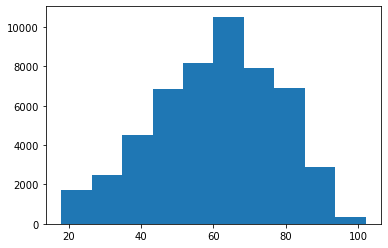

In [35]:
plt.hist(pe_condition_result['age_years'], bins=10)

### History of Cancer

Use [ATLAS concept set #547: cancer, DX](https://ohdsi-atlas.stanford.edu/#/conceptset/547) as the concept set, but narrow down to ICD-9-CM.

In [36]:
cancer_concept_set = pd.read_csv("data/cancer_concept_set.csv")
cancer_concept_set = cancer_concept_set.drop("Unnamed: 0", axis=1)
cancer_concept_set

,Id,Code,Name,Class,Standard Concept Caption,RC,DRC,Domain,Vocabulary,Ancestors
0,45890917,209.7,Secondary neuroendocrine tumors,4-dig nonbill code,Non-Standard,0,0,Condition,ICD9CM,"$parents[1].showAncestorsModal(d.CONCEPT_ID), ..."
1,44837878,V86.0,Estrogen receptor positive status [ER+],4-dig billing V code,Non-Standard,40,40,Condition,ICD9CM,"$parents[1].showAncestorsModal(d.CONCEPT_ID), ..."
2,44837349,719.25,"Villonodular synovitis, pelvic region and thigh",5-dig billing code,Non-Standard,0,0,Condition,ICD9CM,"$parents[1].showAncestorsModal(d.CONCEPT_ID), ..."
3,44836925,258.02,Multiple endocrine neoplasia [MEN] type IIA,5-dig billing code,Non-Standard,0,0,Condition,ICD9CM,"$parents[1].showAncestorsModal(d.CONCEPT_ID), ..."
4,44836924,258.0,Polyglandular activity in multiple endocrine a...,4-dig nonbill code,Non-Standard,0,0,Condition,ICD9CM,"$parents[1].showAncestorsModal(d.CONCEPT_ID), ..."
...,...,...,...,...,...,...,...,...,...,...
1182,44819424,158.0,Malignant neoplasm of retroperitoneum,4-dig billing code,Non-Standard,68,68,Condition,ICD9CM,NaN
1183,44819423,155.0,"Malignant neoplasm of liver, primary",4-dig billing code,Non-Standard,357,357,Condition,ICD9CM,NaN
1184,44819422,147,Malignant neoplasm of nasopharynx,3-dig nonbill code,Non-Standard,0,0,Condition,ICD9CM,NaN
1185,44819421,146.9,"Malignant neoplasm of oropharynx, unspecified ...",4-dig billing code,Non-Standard,172,172,Condition,ICD9CM,NaN


Retrieve concept ID.

In [37]:
cancer_source_concept_id = cancer_concept_set['Id'].astype(str).str.cat(sep=", ")

Map to OMOP.

In [38]:
query = """ 
SELECT 
  * 
FROM
  `{project_id}.{dataset_id}.concept_relationship`
WHERE 
  concept_id_1 IN ({cancer_source_concept_id}) AND
  relationship_id = 'Maps to'
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'cancer_source_concept_id': cancer_source_concept_id})

result = client.query(query).to_dataframe()
result

,concept_id_1,concept_id_2,relationship_id,valid_start_DATE,valid_end_DATE,invalid_reason,load_table_id,load_row_id
0,44832156,134603,Maps to,1970-01-01,2099-12-31,None,athena_vocab,NaN
1,44833291,437798,Maps to,1970-01-01,2099-12-31,None,athena_vocab,NaN
2,44829859,138102,Maps to,2014-10-01,2099-12-31,None,athena_vocab,NaN
3,44820627,373152,Maps to,2012-08-31,2099-12-31,None,athena_vocab,NaN
4,44833351,442105,Maps to,2013-11-27,2099-12-31,None,athena_vocab,NaN
...,...,...,...,...,...,...,...,...
1329,44824038,441803,Maps to,1970-01-01,2099-12-31,None,athena_vocab,NaN
1330,44833684,198810,Maps to,1970-01-01,2099-12-31,None,athena_vocab,NaN
1331,44820612,4300557,Maps to,2013-10-10,2099-12-31,None,athena_vocab,NaN
1332,44833337,4139054,Maps to,2018-02-07,2099-12-31,None,athena_vocab,NaN


In [39]:
cancer_concept_id = ", ".join(result["concept_id_2"].unique().astype(str))

In [40]:
query = """ 
SELECT 
  * 
FROM
  `{project_id}.{dataset_id}.concept`
WHERE 
  domain_id = 'Condition' AND
  concept_id IN ({cancer_concept_id})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'cancer_concept_id': cancer_concept_id})

result = client.query(query).to_dataframe()
result

,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_DATE,valid_end_DATE,invalid_reason,load_table_id,load_row_id
0,320337,Hodgkin's granuloma of lymph nodes of multiple...,Condition,SNOMED,Clinical Finding,S,188541000,1970-01-01,2099-12-31,None,athena_vocab,NaN
1,4167696,Estrogen receptor positive tumor,Condition,SNOMED,Clinical Finding,S,416053008,1970-01-01,2099-12-31,None,athena_vocab,NaN
2,434293,Primary malignant neoplasm of body of pancreas,Condition,SNOMED,Clinical Finding,S,93715005,1970-01-01,2099-12-31,None,athena_vocab,NaN
3,27235,Primary malignant neoplasm of carotid body,Condition,SNOMED,Clinical Finding,S,93740003,1970-01-01,2099-12-31,None,athena_vocab,NaN
4,438086,Primary malignant neoplasm of parietal lobe,Condition,SNOMED,Clinical Finding,S,93946000,1970-01-01,2099-12-31,None,athena_vocab,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
840,196064,Carcinoma in situ of digestive organ,Condition,SNOMED,Clinical Finding,S,109850001,1970-01-01,2099-12-31,None,athena_vocab,NaN
841,24602,Benign neoplasm of esophagus,Condition,SNOMED,Clinical Finding,S,92091003,1970-01-01,2099-12-31,None,athena_vocab,NaN
842,132575,Myeloid sarcoma in remission,Condition,SNOMED,Clinical Finding,S,94718004,1970-01-01,2099-12-31,None,athena_vocab,NaN
843,196044,Primary malignant neoplasm of stomach,Condition,SNOMED,Clinical Finding,S,372014001,1970-01-01,2099-12-31,None,athena_vocab,NaN


Retrieve patients with cancer.

In [41]:
query = """ 
SELECT
  *
FROM
  `{project_id}.{dataset_id}.condition_occurrence`
WHERE
  person_id IN ({cohort_list}) AND
  condition_concept_id IN ({cancer_concept_id})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'cohort_list': cohort_list,
                'cancer_concept_id': cancer_concept_id})

cancer_condition_result = client.query(query).to_dataframe()
cancer_condition_result

,condition_occurrence_id,person_id,condition_concept_id,condition_start_DATE,condition_start_DATETIME,condition_end_DATE,condition_end_DATETIME,condition_type_concept_id,stop_reason,provider_id,visit_occurrence_id,visit_detail_id,condition_source_value,condition_source_concept_id,condition_status_source_value,condition_status_concept_id,trace_id,unit_id,load_table_id
0,46073711,2669378,443392,2015-06-15,2015-06-15 00:00:00,None,NaT,32020,None,175713.0,73905958.0,NaN,199.1,44827567,Admitting diagnosis,4203942,"{""pat_enc_csn_id"":309722625,""line"":1}",condition.rule.2.lpch_hsp_admit_diag,lpch_hsp_admit_diag
1,70737555,3064141,439392,2017-02-07,2017-02-07 00:00:00,None,NaT,32020,None,179680.0,97587369.0,NaN,C80.1,45561836,Admitting diagnosis,4203942,"{""pat_enc_csn_id"":313898951,""line"":2}",condition.rule.2.lpch_hsp_admit_diag,lpch_hsp_admit_diag
2,12740602,467530,437233,2011-12-01,2011-12-01 00:00:00,None,NaT,32020,None,232419.0,45576436.0,NaN,203.00,44833335,None,0,"{""pat_enc_csn_id"":131014406170,""line"":1}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
3,572013,329717,198985,2008-12-23,2008-12-23 00:00:00,None,NaT,32020,None,NaN,31244346.0,NaN,189.0,44819440,None,0,"{""pat_enc_csn_id"":21410492,""line"":1}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
4,10594736,957032,4149840,2011-07-22,2011-07-22 00:00:00,None,NaT,32020,None,291771.0,43843646.0,NaN,202.00,44833325,None,0,"{""pat_enc_csn_id"":131012402004,""line"":2}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345494,33343866,1806687,137809,2014-06-24,2014-06-24 20:14:00,None,NaT,32019,None,NaN,62716497.0,NaN,174.9,44824029,None,0,"{""hsp_account_id"":55423016,""dx_id"":1686}",None,shc_hsp_acct_admit_dx
345495,131426200,918141,137809,2020-02-05,2020-02-05 09:10:00,None,NaT,32019,None,NaN,151129315.0,NaN,C50.912,45556996,None,0,"{""hsp_account_id"":66249500,""dx_id"":1364074}",None,shc_hsp_acct_admit_dx
345496,86498946,933958,137809,2018-01-02,2018-01-02 09:49:00,None,NaT,32019,None,NaN,112083619.0,NaN,C50.911,45586014,None,0,"{""hsp_account_id"":61482508,""dx_id"":1358029}",None,shc_hsp_acct_admit_dx
345497,85763740,548463,137809,2017-12-14,2017-12-14 08:19:00,None,NaT,32019,None,NaN,111483237.0,NaN,C50.911,45586014,None,0,"{""hsp_account_id"":61493459,""dx_id"":1358029}",None,shc_hsp_acct_admit_dx


Double check top 10 conditions.

In [42]:
top10_index = cancer_condition_result.groupby('condition_concept_id').count().sort_values('person_id', ascending=False).head(10).index
top10_conditions = ", ".join(map(str, list(top10_index)))
top10_conditions

'4311499, 137809, 443392, 78097, 140352, 376647, 437233, 200051, 197500, 378087'

In [43]:
query = """ 
SELECT 
  concept_id, concept_name
FROM
  `{project_id}.{dataset_id}.concept`
WHERE 
  concept_id IN ({top10_conditions})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'top10_conditions': top10_conditions})

result = client.query(query).to_dataframe()
result

,concept_id,concept_name
0,437233,Multiple myeloma
1,78097,Secondary malignant neoplasm of bone
2,443392,Malignant neoplastic disease
3,197500,Primary malignant neoplasm of colon
4,376647,Primary malignant neoplasm of soft tissues
5,4311499,Primary malignant neoplasm of respiratory tract
6,140352,"Acute myeloid leukemia, disease"
7,137809,Primary malignant neoplasm of female breast
8,200051,Primary malignant neoplasm of ovary
9,378087,Secondary malignant neoplasm of brain and spin...


In [44]:
def mark_cancer_history(person_id, condition_start_DATE):
    match = cancer_condition_result.query('person_id == @person_id')
    if not match.empty:
        for _, row in match.iterrows():
            if row['condition_start_DATE'] < condition_start_DATE:
                return True
    return False

pe_condition_result['cancer_history'] = pe_condition_result.swifter.progress_bar(True).apply(
    lambda row: mark_cancer_history(row['person_id'], row['condition_start_DATE']), axis=1)

Dask Apply:   0%|          | 0/48 [00:00<?, ?it/s]

/tmp/ipykernel_569152/908908364.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pe_condition_result['cancer_history'] = pe_condition_result.swifter.progress_bar(True).apply(


In [45]:
pe_condition_result['cancer_history'].value_counts()

True     27523
False    24893
Name: cancer_history, dtype: int64

### History of Chronic Cardiopulmonary Disease

[Jimenez et al.](https://jamanetwork.com/journals/jamainternalmedicine/fullarticle/775646) combines heart failure and chronic pulmonary disease into 1, chronic cardiopulmonary disease.

Use concept codes as used in the [Deyo system](https://linkinghub.elsevier.com/retrieve/pii/0895435692901338) to locate heart failure and chronic pulmonary disease instances.

First retrieve concept IDs for heart failure.

In [46]:
heart_failure_concept_code = """
"428",
        "428.0",   
        "428.1",   
        "428.2",   
                "428.20",
                "428.21",
                "428.22",
                "428.23",
        "428.3",   
                "428.30",
                "428.31",
                "428.32",
                "428.33",
        "428.4",   
                "428.40",
                "428.41",
                "428.42",
                "428.43",
        "428.9"  
"""

In [47]:
query = """ 
SELECT 
  * 
FROM
  `{project_id}.{dataset_id}.concept`
WHERE 
  domain_id = 'Condition' AND
  vocabulary_id = 'ICD9CM' AND
  concept_code IN ({heart_failure_concept_code})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'heart_failure_concept_code': heart_failure_concept_code})

result = client.query(query).to_dataframe()
result

,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_DATE,valid_end_DATE,invalid_reason,load_table_id,load_row_id
0,44833574,Combined systolic and diastolic heart failure,Condition,ICD9CM,4-dig nonbill code,None,428.4,1970-01-01,2099-12-31,None,athena_vocab,NaN
1,44826642,"Congestive heart failure, unspecified",Condition,ICD9CM,4-dig billing code,None,428.0,1970-01-01,2099-12-31,None,athena_vocab,NaN
2,44835943,Chronic diastolic heart failure,Condition,ICD9CM,5-dig billing code,None,428.32,1970-01-01,2099-12-31,None,athena_vocab,NaN
3,44835944,Acute on chronic diastolic heart failure,Condition,ICD9CM,5-dig billing code,None,428.33,1970-01-01,2099-12-31,None,athena_vocab,NaN
4,44820869,Acute systolic heart failure,Condition,ICD9CM,5-dig billing code,None,428.21,1970-01-01,2099-12-31,None,athena_vocab,NaN
5,44831248,Chronic systolic heart failure,Condition,ICD9CM,5-dig billing code,None,428.22,1970-01-01,2099-12-31,None,athena_vocab,NaN
6,44827795,Acute combined systolic and diastolic heart fa...,Condition,ICD9CM,5-dig billing code,None,428.41,1970-01-01,2099-12-31,None,athena_vocab,NaN
7,44831250,"Diastolic heart failure, unspecified",Condition,ICD9CM,5-dig billing code,None,428.30,1970-01-01,2099-12-31,None,athena_vocab,NaN
8,44827796,"Heart failure, unspecified",Condition,ICD9CM,4-dig billing code,None,428.9,1970-01-01,2099-12-31,None,athena_vocab,NaN
9,44824250,Heart failure,Condition,ICD9CM,3-dig nonbill code,None,428,1970-01-01,2099-12-31,None,athena_vocab,NaN


Retrieve concept ID.

In [48]:
heart_failure_source_concept_id = ", ".join(result["concept_id"].unique().astype(str))

Map to OMOP.

In [49]:
query = """ 
SELECT 
  * 
FROM
  `{project_id}.{dataset_id}.concept_relationship`
WHERE 
  concept_id_1 IN ({heart_failure_source_concept_id}) AND
  relationship_id = 'Maps to'
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'heart_failure_source_concept_id': heart_failure_source_concept_id})

result = client.query(query).to_dataframe()
result

,concept_id_1,concept_id_2,relationship_id,valid_start_DATE,valid_end_DATE,invalid_reason,load_table_id,load_row_id
0,44832381,40482727,Maps to,2014-07-01,2099-12-31,None,athena_vocab,NaN
1,44831250,443587,Maps to,1970-01-01,2099-12-31,None,athena_vocab,NaN
2,44827796,316139,Maps to,1970-01-01,2099-12-31,None,athena_vocab,NaN
3,44823119,44782733,Maps to,2014-10-01,2099-12-31,None,athena_vocab,NaN
4,44827794,439846,Maps to,1970-01-01,2099-12-31,None,athena_vocab,NaN
5,44830086,443580,Maps to,1970-01-01,2099-12-31,None,athena_vocab,NaN
6,44820869,40480603,Maps to,2013-10-10,2099-12-31,None,athena_vocab,NaN
7,44824251,40481042,Maps to,2013-10-01,2099-12-31,None,athena_vocab,NaN
8,44826642,319835,Maps to,1970-01-01,2099-12-31,None,athena_vocab,NaN
9,44831249,443587,Maps to,1970-01-01,2099-12-31,None,athena_vocab,NaN


In [50]:
heart_failure_concept_id = ", ".join(result["concept_id_2"].unique().astype(str))

In [51]:
query = """ 
SELECT 
  * 
FROM
  `{project_id}.{dataset_id}.concept`
WHERE 
  domain_id = 'Condition' AND
  concept_id IN ({heart_failure_concept_id})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'heart_failure_concept_id': heart_failure_concept_id})

result = client.query(query).to_dataframe()
result

,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_DATE,valid_end_DATE,invalid_reason,load_table_id,load_row_id
0,40482727,Combined systolic and diastolic dysfunction,Condition,SNOMED,Clinical Finding,S,442304009,2009-07-31,2099-12-31,None,athena_vocab,NaN
1,439846,Left heart failure,Condition,SNOMED,Clinical Finding,S,85232009,1970-01-01,2099-12-31,None,athena_vocab,NaN
2,443587,Diastolic heart failure,Condition,SNOMED,Clinical Finding,S,418304008,1970-01-01,2099-12-31,None,athena_vocab,NaN
3,44782719,Chronic combined systolic and diastolic heart ...,Condition,SNOMED,Clinical Finding,S,153941000119100,2014-01-31,2099-12-31,None,athena_vocab,NaN
4,44782733,Acute on chronic combined systolic and diastol...,Condition,SNOMED,Clinical Finding,S,153951000119103,2014-01-31,2099-12-31,None,athena_vocab,NaN
5,40480602,Acute on chronic systolic heart failure,Condition,SNOMED,Clinical Finding,S,443253003,2010-01-31,2099-12-31,None,athena_vocab,NaN
6,443580,Systolic heart failure,Condition,SNOMED,Clinical Finding,S,417996009,1970-01-01,2099-12-31,None,athena_vocab,NaN
7,319835,Congestive heart failure,Condition,SNOMED,Clinical Finding,S,42343007,1970-01-01,2099-12-31,None,athena_vocab,NaN
8,40479192,Chronic systolic heart failure,Condition,SNOMED,Clinical Finding,S,441481004,2009-07-31,2099-12-31,None,athena_vocab,NaN
9,40479576,Chronic diastolic heart failure,Condition,SNOMED,Clinical Finding,S,441530006,2009-07-31,2099-12-31,None,athena_vocab,NaN


Now retrieve concept IDs for chronic pulmonary disease.

In [52]:
chronic_pulmonary_disease_concept_code = """
"490",   
"491",   
        "491.0", 
        "491.1", 
        "491.2", 
                "491.20",
                "491.21",
                "491.22",
        "491.8", 
        "491.9", 
"492",   
        "492.0", 
        "492.8", 
"493",   
        "493.0", 
                "493.00",
                "493.01",
                "493.02",
        "493.1", 
                "493.10",
                "493.11",
                "493.12",
        "493.2", 
                "493.20",
                "493.21",
                "493.22",
        "493.8", 
                "493.81",
                "493.82",
        "493.9", 
                "493.90",
                "493.91",
                "493.92",
"494",   
        "494.0", 
        "494.1", 
"495",   
        "495.0", 
        "495.1", 
        "495.2", 
        "495.3", 
        "495.4", 
        "495.5", 
        "495.6", 
        "495.7", 
        "495.8", 
        "495.9", 
"496",           
"500",           
"501",           
"502",           
"503",           
"504",           
"505",           
        "506.4"
"""

In [53]:
query = """ 
SELECT 
  * 
FROM
  `{project_id}.{dataset_id}.concept`
WHERE 
  domain_id = 'Condition' AND
  vocabulary_id = 'ICD9CM' AND
  concept_code IN ({chronic_pulmonary_disease_concept_code})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'chronic_pulmonary_disease_concept_code': chronic_pulmonary_disease_concept_code})

result = client.query(query).to_dataframe()
result

,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_DATE,valid_end_DATE,invalid_reason,load_table_id,load_row_id
0,44826678,Exercise induced bronchospasm,Condition,ICD9CM,5-dig billing code,None,493.81,1970-01-01,2099-12-31,None,athena_vocab,NaN
1,44837134,Mucopurulent chronic bronchitis,Condition,ICD9CM,4-dig billing code,None,491.1,1970-01-01,2099-12-31,None,athena_vocab,NaN
2,44829014,Pneumonopathy due to inhalation of other dust,Condition,ICD9CM,3-dig billing code,None,504,1970-01-01,2099-12-31,None,athena_vocab,NaN
3,44827823,Bronchiectasis,Condition,ICD9CM,3-dig nonbill code,None,494,1970-01-01,2099-12-31,None,athena_vocab,NaN
4,44824288,Extrinsic asthma with status asthmaticus,Condition,ICD9CM,5-dig billing code,None,493.01,1970-01-01,2099-12-31,None,athena_vocab,NaN
5,44823145,Asbestosis,Condition,ICD9CM,3-dig billing code,None,501,1970-01-01,2099-12-31,None,athena_vocab,NaN
6,44833613,Unspecified allergic alveolitis and pneumonitis,Condition,ICD9CM,4-dig billing code,None,495.9,1970-01-01,2099-12-31,None,athena_vocab,NaN
7,44831278,Extrinsic asthma with (acute) exacerbation,Condition,ICD9CM,5-dig billing code,None,493.02,1970-01-01,2099-12-31,None,athena_vocab,NaN
8,44831279,Intrinsic asthma,Condition,ICD9CM,4-dig nonbill code,None,493.1,1970-01-01,2099-12-31,None,athena_vocab,NaN
9,44829013,"Chronic airway obstruction, not elsewhere clas...",Condition,ICD9CM,3-dig billing code,None,496,1970-01-01,2099-12-31,None,athena_vocab,NaN


Retrieve concept ID.

In [54]:
chronic_pulmonary_disease_source_concept_id = ", ".join(result["concept_id"].unique().astype(str))

Map to OMOP.

In [55]:
query = """ 
SELECT 
  * 
FROM
  `{project_id}.{dataset_id}.concept_relationship`
WHERE 
  concept_id_1 IN ({chronic_pulmonary_disease_source_concept_id}) AND
  relationship_id = 'Maps to'
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'chronic_pulmonary_disease_source_concept_id': chronic_pulmonary_disease_source_concept_id})

result = client.query(query).to_dataframe()
result

,concept_id_1,concept_id_2,relationship_id,valid_start_DATE,valid_end_DATE,invalid_reason,load_table_id,load_row_id
0,44824288,45769442,Maps to,2014-10-01,2099-12-31,None,athena_vocab,NaN
1,44826681,316452,Maps to,1970-01-01,2099-12-31,None,athena_vocab,NaN
2,44829011,261325,Maps to,1970-01-01,2099-12-31,None,athena_vocab,NaN
3,44833613,444084,Maps to,2012-08-31,2099-12-31,None,athena_vocab,NaN
4,44837135,45773005,Maps to,2014-10-01,2099-12-31,None,athena_vocab,NaN
5,44826680,40483342,Maps to,2013-10-10,2099-12-31,None,athena_vocab,NaN
6,44831279,4145497,Maps to,2014-10-01,2099-12-31,None,athena_vocab,NaN
7,44820892,259044,Maps to,2013-10-10,2099-12-31,None,athena_vocab,NaN
8,44825475,438175,Maps to,1970-01-01,2099-12-31,None,athena_vocab,NaN
9,44820890,434975,Maps to,1970-01-01,2099-12-31,None,athena_vocab,NaN


In [56]:
chronic_pulmonary_disease_concept_id = ", ".join(result["concept_id_2"].unique().astype(str))

In [57]:
query = """ 
SELECT 
  * 
FROM
  `{project_id}.{dataset_id}.concept`
WHERE 
  domain_id = 'Condition' AND
  concept_id IN ({chronic_pulmonary_disease_concept_id})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'chronic_pulmonary_disease_concept_id': chronic_pulmonary_disease_concept_id})

result = client.query(query).to_dataframe()
result

,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_DATE,valid_end_DATE,invalid_reason,load_table_id,load_row_id
0,438175,Maple-bark strippers' lung,Condition,SNOMED,Clinical Finding,S,86638007,1970-01-01,2099-12-31,None,athena_vocab,NaN
1,40483342,Acute exacerbation of bronchiectasis,Condition,SNOMED,Clinical Finding,S,445378003,2010-07-31,2099-12-31,None,athena_vocab,NaN
2,255573,Chronic obstructive lung disease,Condition,SNOMED,Clinical Finding,S,13645005,1970-01-01,2099-12-31,None,athena_vocab,NaN
3,434975,Malt-workers' lung,Condition,SNOMED,Clinical Finding,S,25897000,1970-01-01,2099-12-31,None,athena_vocab,NaN
4,261325,Pulmonary emphysema,Condition,SNOMED,Clinical Finding,S,87433001,1970-01-01,2099-12-31,None,athena_vocab,NaN
5,259044,Pneumoconiosis,Condition,SNOMED,Clinical Finding,S,40122008,1970-01-01,2099-12-31,None,athena_vocab,NaN
6,434670,Humidifier lung,Condition,SNOMED,Clinical Finding,S,48347002,1970-01-01,2099-12-31,None,athena_vocab,NaN
7,257905,Mucopurulent chronic bronchitis,Condition,SNOMED,Clinical Finding,S,74417001,1970-01-01,2099-12-31,None,athena_vocab,NaN
8,45769442,Acute severe exacerbation of immunoglobin E-me...,Condition,SNOMED,Clinical Finding,S,708095007,2015-01-31,2099-12-31,None,athena_vocab,NaN
9,45771045,Acute exacerbation of asthma,Condition,SNOMED,Clinical Finding,S,708038006,2015-01-31,2099-12-31,None,athena_vocab,NaN


Join both to form concept IDs for chronic cardiopulmonary disease.

In [58]:
chronic_cardiopulmonary_disease_concept_id = heart_failure_concept_id + ", " + chronic_pulmonary_disease_concept_id

Retrieve patients with chronic cardiopulmonary disease.

In [59]:
query = """ 
SELECT
  *
FROM
  `{project_id}.{dataset_id}.condition_occurrence`
WHERE
  person_id IN ({cohort_list}) AND
  condition_concept_id IN ({chronic_cardiopulmonary_disease_concept_id})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'cohort_list': cohort_list,
                'chronic_cardiopulmonary_disease_concept_id': chronic_cardiopulmonary_disease_concept_id})

chronic_cardiopulmonary_disease_condition_result = client.query(query).to_dataframe()
chronic_cardiopulmonary_disease_condition_result

,condition_occurrence_id,person_id,condition_concept_id,condition_start_DATE,condition_start_DATETIME,condition_end_DATE,condition_end_DATETIME,condition_type_concept_id,stop_reason,provider_id,visit_occurrence_id,visit_detail_id,condition_source_value,condition_source_concept_id,condition_status_source_value,condition_status_concept_id,trace_id,unit_id,load_table_id
0,68341696,1197804,256449,2016-12-13,2016-12-13 00:00:00,None,NaT,32020,None,280076.0,95237312.0,NaN,J47.9,45562459,None,0,"{""pat_enc_csn_id"":131186270645,""line"":4}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
1,9542474,1111475,40483342,2011-05-15,2011-05-15 00:00:00,None,NaT,32020,None,NaN,43009757.0,NaN,494.1,44826680,None,0,"{""pat_enc_csn_id"":131011629952,""line"":10}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
2,81994574,2590566,317009,2017-09-29,2017-09-29 00:00:00,None,NaT,32020,None,262528.0,108045093.0,NaN,J45.998,45572171,None,0,"{""pat_enc_csn_id"":131234159307,""line"":3}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
3,2706346,501291,443580,2010-01-07,2010-01-07 00:00:00,None,NaT,32020,None,189826.0,37511494.0,NaN,428.20,44830086,None,0,"{""pat_enc_csn_id"":131005945342,""line"":2}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
4,63872715,405393,256451,2016-09-01,2016-09-01 00:00:00,None,NaT,32020,None,260374.0,90798264.0,NaN,J40,35208013,None,0,"{""pat_enc_csn_id"":131183417841,""line"":4}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63947,81827921,193925,319835,2017-09-27,2017-09-27 19:06:00,None,NaT,32019,None,NaN,107931907.0,NaN,I50.33,45562355,Yes,4203942,"{""hsp_account_id"":61035907,""dx_id"":1347945}",None,shc_hsp_acct_dx_list
63948,62246860,193925,319835,2016-07-25,2016-07-25 13:10:00,None,NaT,32019,None,NaN,89154471.0,NaN,I50.33,45562355,None,0,"{""hsp_account_id"":58728407,""dx_id"":1347945}",None,shc_hsp_acct_dx_list
63949,58427761,457590,40481043,2016-04-22,2016-04-22 04:17:00,None,NaT,32019,None,NaN,85506910.0,NaN,I50.33,45562355,None,0,"{""hsp_account_id"":58273277,""dx_id"":1347945}",None,shc_hsp_acct_admit_dx
63950,93798194,226438,319835,2018-05-15,2018-05-15 16:04:00,None,NaT,32019,None,NaN,118372477.0,NaN,I50.33,45562355,None,0,"{""hsp_account_id"":60350547,""dx_id"":1347945}",None,shc_hsp_acct_admit_dx


Double check top 10 conditions.

In [60]:
top10_index = chronic_cardiopulmonary_disease_condition_result.groupby('condition_concept_id').count().sort_values('person_id', ascending=False).head(10).index
top10_conditions = ", ".join(map(str, list(top10_index)))
top10_conditions

'319835, 255573, 317009, 316139, 40479576, 256449, 261325, 40479192, 45771045, 46270376'

In [61]:
query = """ 
SELECT 
  concept_id, concept_name
FROM
  `{project_id}.{dataset_id}.concept`
WHERE 
  concept_id IN ({top10_conditions})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'top10_conditions': top10_conditions})

result = client.query(query).to_dataframe()
result

,concept_id,concept_name
0,255573,Chronic obstructive lung disease
1,261325,Pulmonary emphysema
2,319835,Congestive heart failure
3,40479192,Chronic systolic heart failure
4,40479576,Chronic diastolic heart failure
5,45771045,Acute exacerbation of asthma
6,46270376,Acute exacerbation of chronic obstructive bron...
7,317009,Asthma
8,256449,Bronchiectasis
9,316139,Heart failure


In [62]:
def mark_ccd_history(person_id, condition_start_DATE):
    match = chronic_cardiopulmonary_disease_condition_result.query('person_id == @person_id')
    if not match.empty:
        for _, row in match.iterrows():
            if row['condition_start_DATE'] < condition_start_DATE:
                return True
    return False

pe_condition_result['ccd_history'] = pe_condition_result.swifter.progress_bar(True).apply(
    lambda row: mark_ccd_history(row['person_id'], row['condition_start_DATE']), axis=1)

Dask Apply:   0%|          | 0/48 [00:00<?, ?it/s]

/tmp/ipykernel_569152/2075313834.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pe_condition_result['ccd_history'] = pe_condition_result.swifter.progress_bar(True).apply(


In [63]:
pe_condition_result['ccd_history'].value_counts()

False    34614
True     17802
Name: ccd_history, dtype: int64

### Heart Rate

Searching ATLAS for "heart rate" in Measurement domain gives three concepts with non-zero RC:
- [3027018: Heart rate](https://ohdsi-atlas.stanford.edu/#/concept/3027018)
- [4239408: Heart rate](https://ohdsi-atlas.stanford.edu/#/concept/4239408)
- [2000024119: HEART RATE](https://ohdsi-atlas.stanford.edu/#/concept/2000024119)

In [64]:
heart_rate_concept_id = "3027018, 4239408"
heart_rate_source_concept_id = "2000024119"

In [65]:
query = """ 
SELECT
  person_id, measurement_concept_id, measurement_date, unit_source_value, value_source_value, value_as_number
FROM
  `{project_id}.{dataset_id}.measurement`
WHERE
  person_id IN ({cohort_list}) AND
  (measurement_concept_id IN ({heart_rate_concept_id}) OR
   measurement_source_concept_id IN ({heart_rate_source_concept_id})) AND
  (value_source_value != 'None' OR NOT IS_NAN(value_as_number)) 
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'cohort_list': cohort_list,
                'heart_rate_concept_id': heart_rate_concept_id,
                'heart_rate_source_concept_id': heart_rate_source_concept_id})

heart_rate_result = client.query(query).to_dataframe()
heart_rate_result

,person_id,measurement_concept_id,measurement_date,unit_source_value,value_source_value,value_as_number
0,2891281,3027018,2014-03-06,None,None,125.0
1,1292741,3027018,2013-01-16,None,None,49.0
2,263928,3027018,2010-03-29,None,None,133.0
3,1429110,3027018,2020-01-09,None,None,173.0
4,2748086,3027018,2011-11-19,None,None,130.0
...,...,...,...,...,...,...
3185117,2549703,3027018,2010-10-25,None,None,115.0
3185118,1111475,3027018,2012-05-26,None,None,115.0
3185119,1680153,3027018,2011-12-26,None,None,115.0
3185120,1385681,3027018,2017-05-26,bpm,None,115.0


In [66]:
heart_rate_result.groupby('measurement_concept_id').count()

,person_id,measurement_date,unit_source_value,value_source_value,value_as_number
measurement_concept_id,,,,,
3027018,3150590,3150590,673092,0,3150590
4239408,34532,34532,34532,34532,34528


In [67]:
heart_rate_result[np.isnan(heart_rate_result['value_as_number'])]

,person_id,measurement_concept_id,measurement_date,unit_source_value,value_source_value,value_as_number
30101,759857,4239408,2015-04-06,bpm,Invalid,NaN
59187,1244262,4239408,2014-10-04,bpm,Invalid,NaN
121860,257971,4239408,2018-07-18,bpm,Invalid,NaN
156779,496685,4239408,2012-10-21,bpm,Invalid,NaN


In [68]:
# Drop results that do not have value_as_number populated.
heart_rate_result = heart_rate_result[~np.isnan(heart_rate_result['value_as_number'])]

In [69]:
heart_rate_result.groupby('unit_source_value').count()

,person_id,measurement_concept_id,measurement_date,value_source_value,value_as_number
unit_source_value,,,,,
beats per minute,160,160,160,0,160
bpm,707460,707460,707460,34528,707460


In [70]:
# Normalize to bpm.
heart_rate_result['unit_source_value'] = 'bpm'

/tmp/ipykernel_569152/4107434408.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heart_rate_result['unit_source_value'] = 'bpm'


In [71]:
heart_rate_result['value_as_number'].describe()

count    3.185118e+06
mean     8.474486e+01
std      7.629440e+01
min      0.000000e+00
25%      7.100000e+01
50%      8.400000e+01
75%      9.800000e+01
max      1.281280e+05
Name: value_as_number, dtype: float64

CDC describes maximum heart rate as 220: https://www.cdc.gov/physicalactivity/basics/measuring/heartrate.htm.

In [72]:
bpm_cutoff = 220

heart_rate_result = heart_rate_result[heart_rate_result['value_as_number'] < bpm_cutoff]

In [73]:
heart_rate_result['value_as_number'].describe()

count    3.184054e+06
mean     8.462392e+01
std      2.182554e+01
min      0.000000e+00
25%      7.100000e+01
50%      8.400000e+01
75%      9.800000e+01
max      2.190000e+02
Name: value_as_number, dtype: float64

(array([4.03940e+04, 1.36000e+02, 1.94000e+02, 9.33000e+02, 2.36000e+03,
        8.87100e+03, 5.06340e+04, 1.35646e+05, 2.76597e+05, 3.81890e+05,
        4.97767e+05, 4.14432e+05, 4.08270e+05, 3.76349e+05, 2.25908e+05,
        1.51966e+05, 1.04281e+05, 4.91660e+04, 2.63970e+04, 1.43990e+04,
        7.37500e+03, 3.53200e+03, 1.90000e+03, 1.50400e+03, 9.79000e+02,
        5.85000e+02, 5.37000e+02, 4.91000e+02, 2.86000e+02, 2.75000e+02]),
 array([  0. ,   7.3,  14.6,  21.9,  29.2,  36.5,  43.8,  51.1,  58.4,
         65.7,  73. ,  80.3,  87.6,  94.9, 102.2, 109.5, 116.8, 124.1,
        131.4, 138.7, 146. , 153.3, 160.6, 167.9, 175.2, 182.5, 189.8,
        197.1, 204.4, 211.7, 219. ]),
 <BarContainer object of 30 artists>)

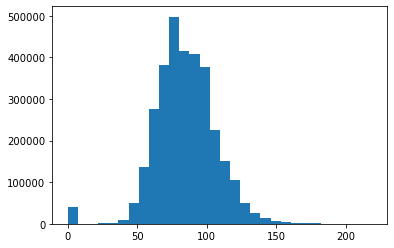

In [74]:
plt.hist(heart_rate_result['value_as_number'], bins=30)

### Systolic BP

Searching ATLAS for "systolic blood pressure" in Measurement domain gives two concepts with non-zero RC:
- [3004249: Systolic blood pressure](https://ohdsi-atlas.stanford.edu/#/concept/3004249)
- [4152194: Systolic blood pressure](https://ohdsi-atlas.stanford.edu/#/concept/4152194)

In [75]:
syst_bp_concept_id = "3004249, 4152194"

In [76]:
query = """ 
SELECT
  person_id, measurement_concept_id, measurement_date, unit_source_value, value_source_value, value_as_number
FROM
  `{project_id}.{dataset_id}.measurement`
WHERE
  person_id IN ({cohort_list}) AND
  measurement_concept_id IN ({syst_bp_concept_id}) AND
  (value_source_value != 'None' OR NOT IS_NAN(value_as_number)) 
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'cohort_list': cohort_list,
                'syst_bp_concept_id': syst_bp_concept_id})

syst_bp_result = client.query(query).to_dataframe()
syst_bp_result

,person_id,measurement_concept_id,measurement_date,unit_source_value,value_source_value,value_as_number
0,1595175,3004249,2014-05-06,None,None,74.0
1,1766692,3004249,2012-10-27,None,None,85.0
2,193925,3004249,2015-12-23,None,None,171.0
3,2206291,3004249,2013-02-24,None,None,70.0
4,520776,3004249,2012-06-21,None,None,163.0
...,...,...,...,...,...,...
2119070,1937826,3004249,2019-05-09,None,None,151.0
2119071,1400379,3004249,2020-09-09,None,None,151.0
2119072,1180019,3004249,2009-12-13,None,None,151.0
2119073,1012010,3004249,2017-12-04,None,None,151.0


In [77]:
syst_bp_result.groupby('measurement_concept_id').count()

,person_id,measurement_date,unit_source_value,value_source_value,value_as_number
measurement_concept_id,,,,,
3004249,1950769,1950769,0,0,1950769
4152194,168306,168306,168306,0,168306


In [78]:
syst_bp_result.groupby('unit_source_value').count()

,person_id,measurement_concept_id,measurement_date,value_source_value,value_as_number
unit_source_value,,,,,
mmHg,168306,168306,168306,0,168306


In [79]:
np.isnan(syst_bp_result['value_as_number']).sum()

0

In [80]:
syst_bp_result['value_as_number'].describe()

count    2.119075e+06
mean     1.198645e+02
std      2.288184e+01
min     -3.400000e+01
25%      1.040000e+02
50%      1.180000e+02
75%      1.340000e+02
max      4.580000e+02
Name: value_as_number, dtype: float64

In [81]:
# Remove results less than 0.
syst_bp_result = syst_bp_result[syst_bp_result['value_as_number'] > 0]

In [82]:
syst_bp_result['value_as_number'].describe()

count    2.118892e+06
mean     1.198753e+02
std      2.285296e+01
min      1.000000e+00
25%      1.040000e+02
50%      1.180000e+02
75%      1.340000e+02
max      4.580000e+02
Name: value_as_number, dtype: float64

(array([1.31000e+02, 2.19000e+02, 9.17000e+02, 5.48300e+03, 3.46520e+04,
        1.65000e+05, 4.39599e+05, 5.76973e+05, 4.85081e+05, 2.50423e+05,
        1.06126e+05, 3.67130e+04, 1.23820e+04, 3.26700e+03, 1.03400e+03,
        4.08000e+02, 2.15000e+02, 1.55000e+02, 3.90000e+01, 2.60000e+01,
        1.40000e+01, 1.40000e+01, 8.00000e+00, 8.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 3.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([  1.        ,  16.23333333,  31.46666667,  46.7       ,
         61.93333333,  77.16666667,  92.4       , 107.63333333,
        122.86666667, 138.1       , 153.33333333, 168.56666667,
        183.8       , 199.03333333, 214.26666667, 229.5       ,
        244.73333333, 259.96666667, 275.2       , 290.43333333,
        305.66666667, 320.9       , 336.13333333, 351.36666667,
        366.6       , 381.83333333, 397.06666667, 412.3       ,
        427.53333333, 442.76666667, 458.        ]),
 <BarContainer object of 30 artists>)

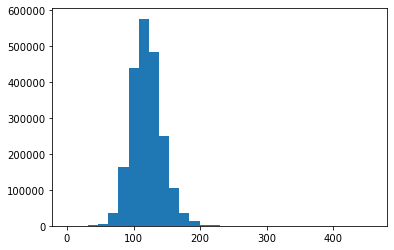

In [83]:
plt.hist(syst_bp_result['value_as_number'], bins=30)

### O2 Saturation

Searching ATLAS for "oxygen saturation" in Measurement domain gives six concepts with non-zero RC:
- [3014295: Oxygen saturation in Arterial cord blood](https://ohdsi-atlas.stanford.edu/#/concept/3014295)
- [42869600: Oxygen saturation [Pure mass fraction] in Venous blood](https://ohdsi-atlas.stanford.edu/#/concept/42869600)
- [3011367: Oxygen saturation Calculated from oxygen partial pressure in Blood](https://ohdsi-atlas.stanford.edu/#/concept/3011367)
- [4020553: Oxygen saturation measurement](https://ohdsi-atlas.stanford.edu/#/concept/4020553)
- [3013502: Oxygen saturation in Blood](https://ohdsi-atlas.stanford.edu/#/concept/3013502)
- [4095044: Venous oxygen saturation measurement](https://ohdsi-atlas.stanford.edu/#/concept/4095044)

In [84]:
oxygen_saturation_concept_id = "3014295, 42869600, 3011367, 4020553, 3013502, 4095044"

In [85]:
query = """ 
SELECT
  person_id, measurement_concept_id, measurement_date, unit_source_value, value_source_value, value_as_number
FROM
  `{project_id}.{dataset_id}.measurement`
WHERE
  person_id IN ({cohort_list}) AND
  measurement_concept_id IN ({oxygen_saturation_concept_id}) AND
  (value_source_value != 'None' OR NOT IS_NAN(value_as_number)) 
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'cohort_list': cohort_list,
                'oxygen_saturation_concept_id': oxygen_saturation_concept_id})

oxygen_saturation_result = client.query(query).to_dataframe()
oxygen_saturation_result

,person_id,measurement_concept_id,measurement_date,unit_source_value,value_source_value,value_as_number
0,1387727,42869600,2020-02-10,%,74.0,74.0
1,1447900,42869600,2012-10-24,%,70,70.0
2,1406339,42869600,2014-10-29,%,62.1,62.1
3,1021190,42869600,2014-02-21,%,60.8,60.8
4,2299666,42869600,2010-02-13,%,73.5,73.5
...,...,...,...,...,...,...
119051,661870,42869600,2004-06-04,%,99,99.0
119052,414860,42869600,2008-09-13,%,99,99.0
119053,189796,42869600,2013-07-11,%,99,99.0
119054,695198,42869600,2010-03-28,%,99,99.0


In [86]:
oxygen_saturation_result.groupby('measurement_concept_id').count()

,person_id,measurement_date,unit_source_value,value_source_value,value_as_number
measurement_concept_id,,,,,
3011367,2713,2713,2713,2713,2713
3013502,64,64,64,64,64
3014295,52921,52921,52921,52921,52882
4020553,1426,1426,1426,1426,1423
4095044,22,22,22,22,22
42869600,61910,61910,61910,61910,61850


In [87]:
oxygen_saturation_result[np.isnan(oxygen_saturation_result['value_as_number'])]

,person_id,measurement_concept_id,measurement_date,unit_source_value,value_source_value,value_as_number
168,1122525,42869600,2011-09-26,%,N/A,NaN
238,853934,42869600,2014-10-19,%,N/A,NaN
423,1139193,42869600,2013-07-29,%,N/A,NaN
675,667572,42869600,2010-03-10,%,N/A,NaN
1012,675401,3014295,2011-05-28,%,N/A,NaN
...,...,...,...,...,...,...
28229,697464,3014295,2011-02-04,%,N/A,NaN
28718,2729436,3014295,2010-10-07,%,N/A,NaN
28777,432539,3014295,2014-11-03,%,N/A,NaN
28953,1006654,3014295,2014-04-03,%,N/A,NaN


In [88]:
# Drop results that do not have value_as_number populated.
oxygen_saturation_result = oxygen_saturation_result[~np.isnan(oxygen_saturation_result['value_as_number'])]

In [89]:
oxygen_saturation_result['value_as_number'].describe()

count    118954.000000
mean         89.544259
std          14.466332
min           6.400000
25%          89.000000
50%          95.000000
75%          98.000000
max         100.000000
Name: value_as_number, dtype: float64

(array([8.0000e+00, 3.2000e+01, 5.9000e+01, 1.0000e+02, 1.2000e+02,
        2.0600e+02, 1.9900e+02, 2.2400e+02, 2.6800e+02, 3.2200e+02,
        3.7100e+02, 4.5200e+02, 5.8200e+02, 8.6200e+02, 8.8200e+02,
        1.0740e+03, 1.3690e+03, 1.6470e+03, 1.8580e+03, 2.1360e+03,
        2.1530e+03, 2.3670e+03, 2.0340e+03, 2.0590e+03, 2.1930e+03,
        3.2260e+03, 5.9720e+03, 1.2585e+04, 2.5314e+04, 4.8280e+04]),
 array([  6.4 ,   9.52,  12.64,  15.76,  18.88,  22.  ,  25.12,  28.24,
         31.36,  34.48,  37.6 ,  40.72,  43.84,  46.96,  50.08,  53.2 ,
         56.32,  59.44,  62.56,  65.68,  68.8 ,  71.92,  75.04,  78.16,
         81.28,  84.4 ,  87.52,  90.64,  93.76,  96.88, 100.  ]),
 <BarContainer object of 30 artists>)

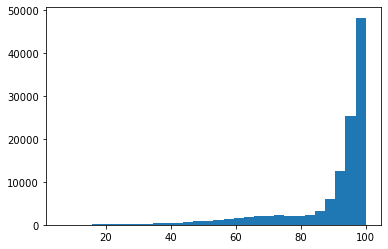

In [90]:
plt.hist(oxygen_saturation_result['value_as_number'], bins=30)

## Compute sPESI

In [91]:
# Join.
pe_condition_result = pd.merge(pe_condition_result[['person_id', 'condition_start_DATE', 'condition_concept_id', 'gender_concept_id', 'birth_DATETIME', 'age_years', 'race_concept_id', 'cancer_history', 'ccd_history']],
                               heart_rate_result[['person_id', 'measurement_date', 'value_as_number']],
                               left_on=['person_id', 'condition_start_DATE'],
                               right_on=['person_id', 'measurement_date'],
                               how='inner')
pe_condition_result = pe_condition_result.drop_duplicates()
pe_condition_result

,person_id,condition_start_DATE,condition_concept_id,gender_concept_id,birth_DATETIME,age_years,race_concept_id,cancer_history,ccd_history,measurement_date,value_as_number
0,1996985,2009-06-02,43530605,8532,1973-06-15,35,8527,False,False,2009-06-02,70.0
2,645334,2011-02-09,43530605,8532,1946-12-22,64,8527,True,False,2011-02-09,103.0
3,601700,2009-07-29,43530605,8532,1945-08-18,63,8527,True,False,2009-07-29,79.0
5,882248,2014-11-25,43530605,8532,1951-07-31,63,8527,True,False,2014-11-25,80.0
6,882248,2014-11-25,43530605,8532,1951-07-31,63,8527,True,False,2014-11-25,86.0
...,...,...,...,...,...,...,...,...,...,...,...
414499,565439,2014-01-06,43530605,8507,1943-09-29,70,8527,True,False,2014-01-06,79.0
414501,565439,2014-01-06,43530605,8507,1943-09-29,70,8527,True,False,2014-01-06,83.0
414504,565439,2014-01-06,43530605,8507,1943-09-29,70,8527,True,False,2014-01-06,87.0
414505,565439,2014-01-06,43530605,8507,1943-09-29,70,8527,True,False,2014-01-06,91.0


In [92]:
pe_condition_result = pd.merge(pe_condition_result,
                               syst_bp_result[['person_id', 'measurement_date', 'value_as_number']],
                               left_on=['person_id', 'condition_start_DATE'],
                               right_on=['person_id', 'measurement_date'],
                               how='inner')
pe_condition_result = pe_condition_result.drop_duplicates()
pe_condition_result

,person_id,condition_start_DATE,condition_concept_id,gender_concept_id,birth_DATETIME,age_years,race_concept_id,cancer_history,ccd_history,measurement_date_x,value_as_number_x,measurement_date_y,value_as_number_y
0,1996985,2009-06-02,43530605,8532,1973-06-15,35,8527,False,False,2009-06-02,70.0,2009-06-02,91.0
2,645334,2011-02-09,43530605,8532,1946-12-22,64,8527,True,False,2011-02-09,103.0,2011-02-09,130.0
3,645334,2011-02-09,43530605,8532,1946-12-22,64,8527,True,False,2011-02-09,103.0,2011-02-09,115.0
5,601700,2009-07-29,43530605,8532,1945-08-18,63,8527,True,False,2009-07-29,79.0,2009-07-29,120.0
7,882248,2014-11-25,43530605,8532,1951-07-31,63,8527,True,False,2014-11-25,80.0,2014-11-25,108.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5517907,565439,2014-01-06,43530605,8507,1943-09-29,70,8527,True,False,2014-01-06,91.0,2014-01-06,130.0
5517909,565439,2014-01-06,43530605,8507,1943-09-29,70,8527,True,False,2014-01-06,91.0,2014-01-06,102.0
5517910,565439,2014-01-06,43530605,8507,1943-09-29,70,8527,True,False,2014-01-06,91.0,2014-01-06,126.0
5517911,565439,2014-01-06,43530605,8507,1943-09-29,70,8527,True,False,2014-01-06,91.0,2014-01-06,140.0


In [93]:
pe_condition_result = pd.merge(pe_condition_result,
                               oxygen_saturation_result[['person_id', 'measurement_date', 'value_as_number']],
                               left_on=['person_id', 'condition_start_DATE'],
                               right_on=['person_id', 'measurement_date'],
                               how='inner')
pe_condition_result = pe_condition_result.drop_duplicates()
pe_condition_result

,person_id,condition_start_DATE,condition_concept_id,gender_concept_id,birth_DATETIME,age_years,race_concept_id,cancer_history,ccd_history,measurement_date_x,value_as_number_x,measurement_date_y,value_as_number_y,measurement_date,value_as_number
0,1180019,2009-02-08,43530605,8532,1957-09-25,51,8515,False,False,2009-02-08,72.0,2009-02-08,121.0,2009-02-08,70.6
1,1180019,2009-02-08,43530605,8532,1957-09-25,51,8515,False,False,2009-02-08,72.0,2009-02-08,138.0,2009-02-08,70.6
2,1180019,2009-02-08,43530605,8532,1957-09-25,51,8515,False,False,2009-02-08,72.0,2009-02-08,131.0,2009-02-08,70.6
3,1180019,2009-02-08,43530605,8532,1957-09-25,51,8515,False,False,2009-02-08,72.0,2009-02-08,127.0,2009-02-08,70.6
4,1180019,2009-02-08,43530605,8532,1957-09-25,51,8515,False,False,2009-02-08,85.0,2009-02-08,121.0,2009-02-08,70.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14761477,107584,2013-12-02,43530605,8532,1921-07-25,92,8527,False,True,2013-12-02,75.0,2013-12-02,146.0,2013-12-02,61.0
14761478,107584,2013-12-02,43530605,8532,1921-07-25,92,8527,False,True,2013-12-02,75.0,2013-12-02,131.0,2013-12-02,61.0
14761479,107584,2013-12-02,43530605,8532,1921-07-25,92,8527,False,True,2013-12-02,75.0,2013-12-02,132.0,2013-12-02,61.0
14761480,107584,2013-12-02,43530605,8532,1921-07-25,92,8527,False,True,2013-12-02,75.0,2013-12-02,141.0,2013-12-02,61.0


In [94]:
# Tidy-up.
pe_condition_result = pe_condition_result.drop(['measurement_date_x', 'measurement_date_y', 'measurement_date'], axis=1)
pe_condition_result = pe_condition_result.rename(columns={"value_as_number_x": "heart_rate_bpm",
                                                          "value_as_number_y": "syst_bp_mmhg",
                                                          "value_as_number": "o2_saturation"})
pe_condition_result

,person_id,condition_start_DATE,condition_concept_id,gender_concept_id,birth_DATETIME,age_years,race_concept_id,cancer_history,ccd_history,heart_rate_bpm,syst_bp_mmhg,o2_saturation
0,1180019,2009-02-08,43530605,8532,1957-09-25,51,8515,False,False,72.0,121.0,70.6
1,1180019,2009-02-08,43530605,8532,1957-09-25,51,8515,False,False,72.0,138.0,70.6
2,1180019,2009-02-08,43530605,8532,1957-09-25,51,8515,False,False,72.0,131.0,70.6
3,1180019,2009-02-08,43530605,8532,1957-09-25,51,8515,False,False,72.0,127.0,70.6
4,1180019,2009-02-08,43530605,8532,1957-09-25,51,8515,False,False,85.0,121.0,70.6
...,...,...,...,...,...,...,...,...,...,...,...,...
14761477,107584,2013-12-02,43530605,8532,1921-07-25,92,8527,False,True,75.0,146.0,61.0
14761478,107584,2013-12-02,43530605,8532,1921-07-25,92,8527,False,True,75.0,131.0,61.0
14761479,107584,2013-12-02,43530605,8532,1921-07-25,92,8527,False,True,75.0,132.0,61.0
14761480,107584,2013-12-02,43530605,8532,1921-07-25,92,8527,False,True,75.0,141.0,61.0


In [95]:
def spesi(age_years, cancer_history, ccd_history, heart_rate_bpm, syst_bp_mmhg, o2_saturation):            
    score = 0
        
    # 1. Age > 80 years
    if age_years > 80:
        score += 1
    
    # 2. History of cancer
    if cancer_history == True:
        score += 1

    # 3. History of chronic cardiopulmonary disease
    if ccd_history == True:
        score += 1   
    
    # 4. Heart rate, bpm
    if heart_rate_bpm >= 110:
        score += 1
        
    # 5. Systolic BP, mmHg
    if syst_bp_mmhg < 100:
        score += 1

    # 6. O₂ saturation
    if o2_saturation < 90:
        score += 1
        
    return score
    
pe_condition_result['spesi'] = pe_condition_result.swifter.progress_bar(True).apply(
    lambda row: spesi(row['age_years'], row['cancer_history'], row['ccd_history'], row['heart_rate_bpm'], row['syst_bp_mmhg'], row['o2_saturation']), axis=1)

Dask Apply:   0%|          | 0/48 [00:00<?, ?it/s]

(array([ 625754., 1896427., 2349704., 1511486.,  570096.,  110013.,
           6927.]),
 array([0, 1, 2, 3, 4, 5, 6, 7]),
 <BarContainer object of 7 artists>)

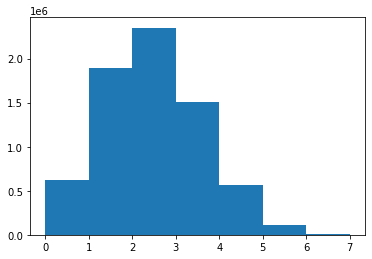

In [96]:
plt.hist(pe_condition_result['spesi'], bins=range(0, 8))

## Obtain Cohort Statistics

In [97]:
pe_condition_result.groupby('race_concept_id').count()

,person_id,condition_start_DATE,condition_concept_id,gender_concept_id,birth_DATETIME,age_years,cancer_history,ccd_history,heart_rate_bpm,syst_bp_mmhg,o2_saturation,spesi
race_concept_id,,,,,,,,,,,,
8515,722301,722301,722301,722301,722301,722301,722301,722301,722301,722301,722301,722301
8516,283029,283029,283029,283029,283029,283029,283029,283029,283029,283029,283029,283029
8527,4754218,4754218,4754218,4754218,4754218,4754218,4754218,4754218,4754218,4754218,4754218,4754218
8557,36142,36142,36142,36142,36142,36142,36142,36142,36142,36142,36142,36142
8657,696,696,696,696,696,696,696,696,696,696,696,696
38003563,1274021,1274021,1274021,1274021,1274021,1274021,1274021,1274021,1274021,1274021,1274021,1274021


In [98]:
pe_condition_result.groupby('gender_concept_id').count()

,person_id,condition_start_DATE,condition_concept_id,birth_DATETIME,age_years,race_concept_id,cancer_history,ccd_history,heart_rate_bpm,syst_bp_mmhg,o2_saturation,spesi
gender_concept_id,,,,,,,,,,,,
8507,4368876,4368876,4368876,4368876,4368876,4368876,4368876,4368876,4368876,4368876,4368876,4368876
8532,2701531,2701531,2701531,2701531,2701531,2701531,2701531,2701531,2701531,2701531,2701531,2701531


In [99]:
pe_condition_result['age_years'].describe()

count    7.070407e+06
mean     5.789593e+01
std      1.636937e+01
min      1.800000e+01
25%      4.900000e+01
50%      6.000000e+01
75%      7.000000e+01
max      1.000000e+02
Name: age_years, dtype: float64

In [100]:
pe_condition_result['cancer_history'].value_counts()

False    3916265
True     3154142
Name: cancer_history, dtype: int64

In [101]:
pe_condition_result['ccd_history'].value_counts()

True     3562562
False    3507845
Name: ccd_history, dtype: int64

In [102]:
pe_condition_result['heart_rate_bpm'].describe()

count    7.070407e+06
mean     9.477914e+01
std      2.984588e+01
min      0.000000e+00
25%      7.600000e+01
50%      9.300000e+01
75%      1.110000e+02
max      2.190000e+02
Name: heart_rate_bpm, dtype: float64

In [103]:
pe_condition_result['syst_bp_mmhg'].describe()

count    7.070407e+06
mean     1.137631e+02
std      3.074816e+01
min      1.000000e+00
25%      9.300000e+01
50%      1.120000e+02
75%      1.320000e+02
max      3.580000e+02
Name: syst_bp_mmhg, dtype: float64

In [104]:
pe_condition_result['o2_saturation'].describe()

count    7.070407e+06
mean     8.712114e+01
std      1.537733e+01
min      1.000000e+01
25%      8.100000e+01
50%      9.400000e+01
75%      9.750000e+01
max      1.000000e+02
Name: o2_saturation, dtype: float64

## Survival Analysis

### Create Survival Table

In [105]:
def death_event(person_id, condition_start_DATE):
    # sPESI predicts survival over a 30 day period.
    time_window = datetime.timedelta(days=30)
    
    # Did the patient die?
    match = death_result.query('person_id == @person_id')
    if not match.empty:
        for _, row in match.iterrows():
            if row['death_DATE'] >= condition_start_DATE and \
               row['death_DATE'] < condition_start_DATE + time_window:
                return pd.Series([row['death_DATE'], None])
    
    # Patient is censored at the end of the window.
    return pd.Series([None, condition_start_DATE + time_window])
    
pe_condition_result[['death_DATE', 'censure_DATE']] = pe_condition_result.swifter.progress_bar(True).apply(
    lambda row: death_event(row['person_id'], row['condition_start_DATE']), axis=1)

Dask Apply:   0%|          | 0/48 [00:00<?, ?it/s]

In [106]:
pe_condition_result['T'], pe_condition_result['E'] = lifelines.utils.datetimes_to_durations(start_times=pe_condition_result['condition_start_DATE'],
                                                                                            end_times=pe_condition_result['death_DATE'],
                                                                                            fill_date=pe_condition_result['censure_DATE'])

In [107]:
pe_condition_result.groupby('T').count()

,person_id,condition_start_DATE,condition_concept_id,gender_concept_id,birth_DATETIME,age_years,race_concept_id,cancer_history,ccd_history,heart_rate_bpm,syst_bp_mmhg,o2_saturation,spesi,death_DATE,censure_DATE,E
T,,,,,,,,,,,,,,,,
0.0,141950,141950,141950,141950,141950,141950,141950,141950,141950,141950,141950,141950,141950,141950,0,141950
1.0,233289,233289,233289,233289,233289,233289,233289,233289,233289,233289,233289,233289,233289,233289,0,233289
2.0,114005,114005,114005,114005,114005,114005,114005,114005,114005,114005,114005,114005,114005,114005,0,114005
3.0,112026,112026,112026,112026,112026,112026,112026,112026,112026,112026,112026,112026,112026,112026,0,112026
4.0,92098,92098,92098,92098,92098,92098,92098,92098,92098,92098,92098,92098,92098,92098,0,92098
5.0,118698,118698,118698,118698,118698,118698,118698,118698,118698,118698,118698,118698,118698,118698,0,118698
6.0,71258,71258,71258,71258,71258,71258,71258,71258,71258,71258,71258,71258,71258,71258,0,71258
7.0,107311,107311,107311,107311,107311,107311,107311,107311,107311,107311,107311,107311,107311,107311,0,107311
8.0,42111,42111,42111,42111,42111,42111,42111,42111,42111,42111,42111,42111,42111,42111,0,42111


### Study sPESI Concordance

In [108]:
input_group = None
input_stat_fn = None

def gen_sample_and_get_stat(seed):
    # Obtain a bootstrap sample then apply statistics.
    global input_group
    global input_stat_fn
    return input_stat_fn(input_group.sample(frac=1, replace=True, random_state=seed))
        
# Compute confidence interval using parallel bootstrapping.
def bootstrap_ci(group, stat_fn):
    bootstraps = 1000
    alpha = 95
    chunksize = int(bootstraps / os.cpu_count())
    
    global input_group
    input_group = group
    
    global input_stat_fn
    input_stat_fn = stat_fn

    pool_obj = multiprocessing.Pool()
    
    # Obtain a population of statistics.
    stats = []
    for stat in pool_obj.imap_unordered(gen_sample_and_get_stat, range(bootstraps), chunksize):
        stats.append(stat)
        
    pool_obj.close()
    pool_obj.join()
        
    # Caculate mean.
    mean = np.mean(stats)

    # Calculate confidence interval.
    ordered = np.sort(stats)
    lower = np.percentile(ordered, (100 - alpha) / 2)
    upper = np.percentile(ordered, alpha + ((100 - alpha) / 2))
    
    return (mean, lower, upper)

In [109]:
def compute_concordance(group):
    return lifelines.utils.concordance_index(group['T'], -group['spesi'], group['E'])

In [110]:
(c, lower, upper) = bootstrap_ci(pe_condition_result, compute_concordance)
print("c: {:.2f} (CI: {:.2f}~{:.2f})".format(c, lower, upper))

c: 0.59 (CI: 0.59~0.59)


In [111]:
# Obtain c-statistic for each race group.
for race, group in pe_condition_result.groupby('race_concept_id'):
    try:
        (c, lower, upper) = bootstrap_ci(group, compute_concordance)
        print("Race: {}, c: {:.2f} (CI: {:.2f}~{:.2f})".format(race_map[race], c, lower, upper))
    except:
        print("Race: {}, c: N/A".format(race_map[race]))

Race: Asian, c: 0.51 (CI: 0.50~0.51)
Race: Black, c: 0.48 (CI: 0.48~0.49)
Race: White, c: 0.61 (CI: 0.61~0.61)
Race: Pacific Islander, c: 0.17 (CI: 0.17~0.18)
Race: Native American, c: 0.89 (CI: 0.83~0.95)
Race: Hispanic, c: 0.59 (CI: 0.58~0.59)


In [112]:
# Obtain c-statistic for each gender.
for gender, group in pe_condition_result.groupby('gender_concept_id'):
    (c, lower, upper) = bootstrap_ci(group, compute_concordance)
    print("Gender: {}, c: {:.2f} (CI: {:.2f}~{:.2f})".format(gender_map[gender], c, lower, upper))

Gender: Male, c: 0.59 (CI: 0.59~0.59)
Gender: Female, c: 0.60 (CI: 0.60~0.60)


### Observe Negative Incidents

In [113]:
def calibration(group):
    total = len(group)
    event = len(group[group['E'] == True])
    return event / total * 100

Patients with sPESI score 0 are considered for early discharge.

Observe stratification across race.

In [114]:
for race, group in pe_condition_result[pe_condition_result['spesi'] == 0].groupby('race_concept_id'):
    (ratio, lower, upper) = bootstrap_ci(group, calibration)
    print("Race: {}, percentage: {:.2f} (CI: {:.2f}~{:.2f})".format(race_map[race], ratio, lower, upper))

Race: Asian, percentage: 6.89 (CI: 6.68~7.11)
Race: Black, percentage: 38.36 (CI: 37.61~39.16)
Race: White, percentage: 13.81 (CI: 13.70~13.91)
Race: Pacific Islander, percentage: 99.05 (CI: 98.65~99.36)
Race: Hispanic, percentage: 5.50 (CI: 5.37~5.63)


Observe stratification across gender.

In [116]:
for gender, group in pe_condition_result[pe_condition_result['spesi'] == 0].groupby('gender_concept_id'):
    (ratio, lower, upper) = bootstrap_ci(group, calibration)
    print("Gender: {}, percentage: {:.2f} (CI: {:.2f}~{:.2f})".format(gender_map[gender], ratio, lower, upper))

Gender: Male, percentage: 12.33 (CI: 12.24~12.43)
Gender: Female, percentage: 12.65 (CI: 12.49~12.80)


Observe calibation across race.

In [117]:
race_calibration = []

for cutoff in range(0, 7):
    print("Cutoff: {}".format(cutoff))
    for race, group in pe_condition_result[pe_condition_result['spesi'] == cutoff].groupby('race_concept_id'):
        (ratio, lower, upper) = bootstrap_ci(group, calibration)
        race_calibration.append([cutoff, race, ratio, lower, upper])

Cutoff: 0
Cutoff: 1
Cutoff: 2
Cutoff: 3
Cutoff: 4
Cutoff: 5
Cutoff: 6


In [118]:
race_calibration = pd.DataFrame(data=race_calibration,
                                columns=['spesi', 'race_concept_id', 'calibration', 'lower', 'upper'])
race_calibration

,spesi,race_concept_id,calibration,lower,upper
0,0,8515,6.891367,6.677841,7.106297
1,0,8516,38.363036,37.613702,39.162049
2,0,8527,13.809507,13.702609,13.909605
3,0,8557,99.045581,98.646497,99.363057
4,0,38003563,5.502581,5.371638,5.628550
5,1,8515,17.973224,17.788684,18.163601
6,1,8516,22.882727,22.533723,23.240158
7,1,8527,20.585443,20.518783,20.656305
8,1,8557,26.073453,25.374345,26.761083
9,1,8657,0.000000,0.000000,0.000000


In [119]:
reduced_race_map = {
    8515: 'Asian', 
    8516: 'Black', 
    8527: 'White', 
    38003563: 'Hispanic'
}

Text(0.5, 0, 'sPESI Score')

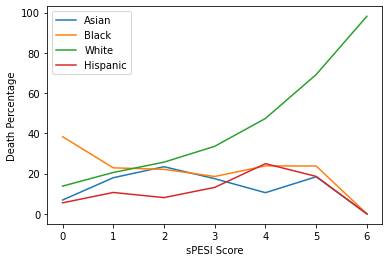

In [120]:
for race, group in race_calibration.groupby('race_concept_id'):
    if race not in reduced_race_map.keys():
        continue
    plt.plot(group['spesi'], group['calibration'], label=race_map[race])
    
plt.legend(loc='upper left')
plt.ylabel("Death Percentage")
plt.xlabel("sPESI Score")